3: RESEAU DE NEURONES
Le réseaux de neurones va prédire la note de la même manière que le Softmax, mais après plus d'étapes de transformations des données.
On va créer nos modèles grâce à TensorFlow.

Préparation des données: (pareil)

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


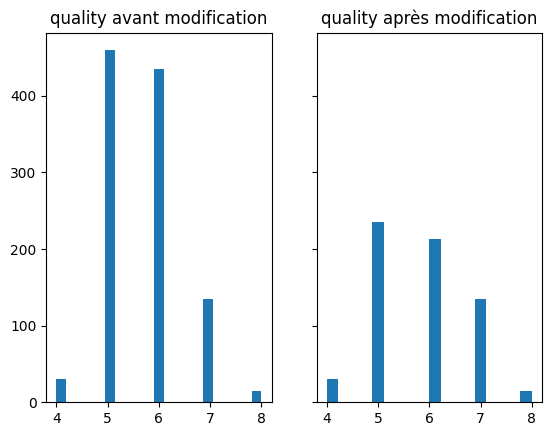

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_train, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cv, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_test, X_mu, X_sigma = zscore_normalize_features(X_test)

Créations de 3 modèles de réseau de neurones avec des architectures différentes :

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from matplotlib.widgets import Slider
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [161]:
tf.random.set_seed(20)

In [162]:

def build_models():
    
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]

    return model_list

In [163]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [164]:

def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

def calcul_error(yhat,y_test):
   
    cost = 0.0
    m=len(y_test)
    for i in range(m):                                
        cost = cost + (y_test[i] - yhat[i])**2   #scalar
    cost = cost / (2 * m)                 #scalar    
    return cost

In [165]:
X_train = np.tile(X_train,(100,1))
y_train= np.transpose(np.tile(y_train,(1,100))   )
print(X_train.shape, y_train.shape)  

(37600, 10) (37600, 1)


Entraînement et évaluation de nos modèles

In [170]:
# Setup the loss and optimizer
def try_model(model):
    
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    )

    print(f"Training {model.name}...")
    
    
    # Train the model
    model.fit(
        X_train, y_train,
        epochs=10,
        verbose=0
    )
    print("Done!\n")

    # Record the fraction of misclassified examples for the training set
    predictions = model.predict(X_train)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    train_error = calcul_error(yhat,y_train)

    # Record the fraction of misclassified examples for the cross validation set
    predictions = model.predict(X_cv)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    cv_error = calcul_error(yhat,y_cv)
    return(train_error,cv_error)

In [171]:

from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models = build_models()

# Loop over the the models
for model in nn_models:
    
    train_error,cv_error=try_model(model)
    nn_train_error.append(train_error)
    nn_cv_error.append(cv_error)

    
# Print the result
for model_num in range(len(nn_train_error)):
    print("Model ",model_num,": Training Set Classification Error:",
          nn_train_error[model_num],"CV Set Classification Error:",nn_cv_error[model_num])


Training model_1...
Done!

4/4 [==============================] - 0s 2ms/step
Training model_2...
Done!

4/4 [==============================] - 0s 1ms/step
Training model_3...
Done!

4/4 [==============================] - 0s 1ms/step
Model  0 : Training Set Classification Error: [0.] CV Set Classification Error: 0.4087301587301587
Model  1 : Training Set Classification Error: [0.] CV Set Classification Error: 0.4246031746031746
Model  2 : Training Set Classification Error: [0.] CV Set Classification Error: 0.4444444444444444


On choisit le premier modèle car il a l'erreur la plus faible sur le jeu cv.

VISUALISATION et TEST DU MODELE CHOISI  : d'abord sur le jeu d'entrainement puis sur le jeu de test

In [172]:
def predict_model(model,X,y):
# Select the model with the lowest error

    # Compute the test error
    predictions = model.predict(X)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    print(yhat)
    print(y)
    print(f"Selected Model: {model_num}")
    sum=0
    for loop in range(len(yhat)):
        if(y[loop] == yhat[loop]):
            sum+=1
    print('Train Accuracy (%): ',(sum/len(yhat))*100)

    nn_test_error =calcul_error(yhat,y)

    print(f"Set Classification Error: {nn_test_error:.4f}")

In [174]:
model_num = 1
model=nn_models[model_num-1]
predict_model(model,X_test,y_test)



4/4 [==============================] - 0s 1ms/step
[5. 7. 6. 5. 5. 5. 7. 7. 7. 5. 5. 6. 5. 5. 6. 5. 5. 7. 6. 5. 6. 5. 6. 7.
 6. 5. 5. 5. 6. 7. 6. 5. 6. 6. 7. 6. 7. 8. 6. 5. 6. 5. 4. 4. 5. 7. 5. 6.
 5. 5. 6. 6. 7. 5. 5. 5. 5. 6. 8. 7. 5. 6. 6. 5. 7. 5. 7. 7. 7. 6. 5. 5.
 7. 7. 4. 6. 7. 5. 5. 7. 5. 6. 6. 7. 7. 6. 6. 5. 5. 6. 5. 5. 5. 5. 5. 5.
 7. 6. 5. 7. 6. 5. 5. 6. 6. 5. 7. 7. 6. 6. 7. 7. 8. 6. 6. 5. 5. 6. 5. 5.
 5. 4. 5. 5. 5. 6.]
[6 7 5 5 5 6 6 7 7 6 5 6 5 4 6 5 5 7 6 6 5 5 5 7 6 4 5 6 5 7 6 5 6 5 7 7 6
 8 6 5 6 5 5 4 5 5 5 4 5 5 6 6 8 5 7 5 5 7 7 6 6 4 6 5 7 7 5 7 6 7 4 6 6 7
 5 6 6 5 5 7 5 5 6 5 7 6 5 6 6 5 5 6 6 5 5 5 7 6 5 7 5 5 6 5 6 6 7 5 5 6 7
 7 8 7 5 6 6 5 7 6 5 5 6 5 6 6]
Selected Model: 1
Train Accuracy (%):  53.96825396825397
Set Classification Error: 0.3373


In [175]:
def plot_predict_model(model,X,y):
    predictions = model.predict(X)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])

    sum=0
    for loop in range(len(yhat)):
        if(y[loop] == yhat[loop]):
            sum+=1
    print('Train Accuracy (%): ',(sum/len(yhat))*100)

    nn_test_error =calcul_error(yhat,y)

    print("Set Classification Error:",nn_test_error)

    m = X.shape[0]

        # plot predictions and targets versus original features    
    fig,ax=plt.subplots(1,nb_feature,figsize=(20, 3),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter([X[:,i]],y, label = 'target')
        ax[i].set_xlabel(X_features[i])
        ax[i].scatter([X[:len(yhat),i]],yhat,color="orange", label = 'predict')
    ax[0].set_ylabel("Quality"); ax[0].legend()
    fig.suptitle("target versus prediction using Reseau de Neurones avec Softmax")
    plt.show()

1175/1175 [==============================] - 1s 864us/step
Train Accuracy (%):  100.0
Set Classification Error: [0.]


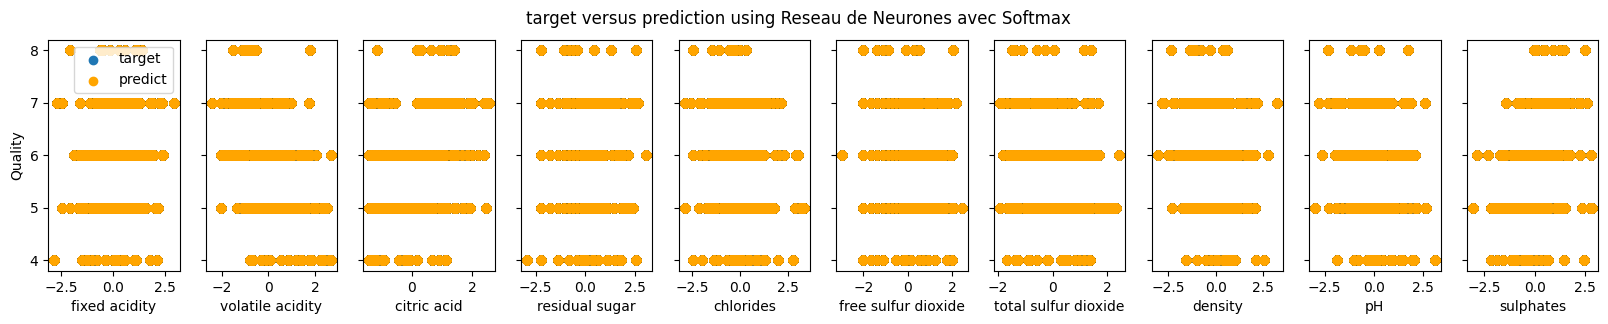

In [176]:
model_num = 1
model=nn_models[model_num-1]
plot_predict_model(model,X_train,y_train)


4/4 [==============================] - 0s 2ms/step
Train Accuracy (%):  49.2063492063492
Set Classification Error: 0.4166666666666667


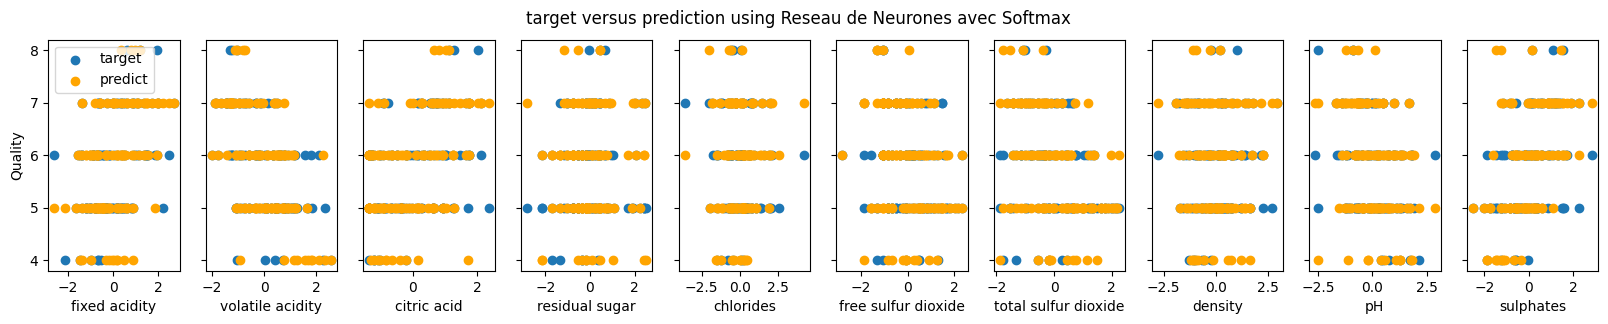

In [177]:
model_num = 2
model=nn_models[model_num-1]
plot_predict_model(model,X_test,y_test)


Le modèle parait plus adapté, mais on voit un autre type de problème : une grande variance. En effet on ne réalise aucune erreur sur le jeu d'entraînement mais on obtient que 50% de précision sur le jeu de test.

REGULARISATION DU MODELE: On va rajouter un parametre de régularisation Lambda en gardant le meme modèle.

In [181]:
from tensorflow.keras.regularizers import l2
def build_models_Regularized():
    lambdas=[0.00,0.01,0.1]
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(25, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(15, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(9, activation = 'softmax',kernel_regularizer=l2(lambdas[0]))
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(25, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(15, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(9, activation = 'softmax',kernel_regularizer=l2(lambdas[1]))
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(25, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(15, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(9, activation = 'softmax',kernel_regularizer=l2(lambdas[2]))
        ],
        name='model_3'
    )
    model_list = [model_1, model_2, model_3]
    return model_list

In [184]:
from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models_r = build_models_Regularized()

# Loop over the the models
for model in nn_models_r:
    
    train_error,cv_error=try_model(model)
    nn_train_error.append(train_error)
    nn_cv_error.append(cv_error)
    
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        "Model",(model_num+1),": Training Set Classification Error:", nn_train_error[model_num],
        "CV Set Classification Error:", nn_cv_error[model_num])
        

Training model_1...
Done!

4/4 [==============================] - 0s 1ms/step
Training model_2...
Done!

4/4 [==============================] - 0s 1ms/step
Training model_3...
Done!

4/4 [==============================] - 0s 1ms/step
Model 1 : Training Set Classification Error: [0.00132979] CV Set Classification Error: 0.3968253968253968
Model 2 : Training Set Classification Error: [0.21675532] CV Set Classification Error: 0.2896825396825397
Model 3 : Training Set Classification Error: [0.44946809] CV Set Classification Error: 0.4007936507936508


In [185]:
# Select the model with the lowest error
model_num = 2
model=nn_models_r[model_num-1]
predict_model(model,X_test,y_test)


4/4 [==============================] - 0s 1ms/step
[6. 7. 5. 6. 5. 5. 6. 7. 7. 6. 5. 6. 6. 5. 6. 5. 6. 7. 7. 5. 6. 5. 6. 6.
 6. 5. 5. 5. 6. 7. 6. 5. 6. 6. 6. 6. 7. 7. 6. 5. 6. 5. 5. 5. 5. 6. 5. 5.
 5. 5. 6. 6. 7. 5. 5. 5. 5. 6. 7. 7. 6. 6. 6. 5. 7. 7. 7. 6. 7. 6. 6. 6.
 7. 7. 5. 6. 6. 5. 5. 7. 5. 7. 6. 7. 7. 6. 5. 6. 5. 6. 5. 7. 6. 5. 5. 6.
 7. 6. 5. 7. 5. 5. 5. 5. 5. 5. 7. 6. 6. 6. 7. 7. 7. 6. 5. 6. 5. 6. 5. 5.
 5. 5. 6. 5. 5. 6.]
[6 7 5 5 5 6 6 7 7 6 5 6 5 4 6 5 5 7 6 6 5 5 5 7 6 4 5 6 5 7 6 5 6 5 7 7 6
 8 6 5 6 5 5 4 5 5 5 4 5 5 6 6 8 5 7 5 5 7 7 6 6 4 6 5 7 7 5 7 6 7 4 6 6 7
 5 6 6 5 5 7 5 5 6 5 7 6 5 6 6 5 5 6 6 5 5 5 7 6 5 7 5 5 6 5 6 6 7 5 5 6 7
 7 8 7 5 6 6 5 7 6 5 5 6 5 6 6]
Selected Model: 2
Train Accuracy (%):  60.317460317460316
Set Classification Error: 0.2817


On a un grand biais, il faut ajouter des features ou des polynomial features (alcohol^2, alcohol*sulfates...)